<a href="https://colab.research.google.com/github/Naga-SDonepudi/PyTorch_HandsOn/blob/main/5_custom_datasets_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working with custom datasets using PyTorch

### 1. Setting up device agnostic code
* Before jumping into main step, PyTorch has different existing data loading functions for each problem
  * If the data is vision, look into TorchVision
  * If the data is text, then TorchText followed by TorchAudio and TorchRec for audio and recommendation problems respectively.


In [1]:
import torch
from torch import nn

torch.__version__

'2.9.0+cpu'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2. Gathering the data
* Used Food101 dataset by creating a subset.
* The original dataset has 101 classes / categories with 1000 images in each class
* The custom data i have created will be with 3 classes and 100 images per each class(75 train inages & 25 for testing)
* Always a good idea to start with smaller data, then increasing the scale when required.

In [3]:
import requests
import zipfile
from pathlib import Path

# Data Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} skipping the download, as directory exists")
else:
  print(f"{image_path} creating a directory")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

# Unzipping the fil
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi related data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi creating a directory
Unzipping pizza, steak and sushi related data


### 3. Data preparation, pre-processing and exploration

In [4]:
import os
def walk_through_directory(dir_path):
  """
  Returns the content of every single directory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images '{dirpath}'.")

In [5]:
walk_through_directory(image_path)

There are 2 directories and 0 images 'data/pizza_steak_sushi'.
There are 3 directories and 0 images 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images 'data/pizza_steak_sushi/test/steak'.


In [6]:
### Training an testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing the image


Random Image Path: data/pizza_steak_sushi/train/sushi/377047.jpg
Image Class: sushi
Image Height: 512
Image width: 382


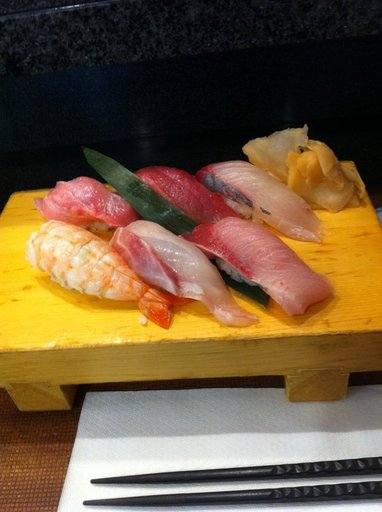

In [7]:
import random
from PIL import Image

random.seed(42)

## Getting the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

## picking and selecting a random image
random_image = random.choice(image_path_list)

## Image class from path name
image_class = random_image.parent.stem

## Opening and Viewing the image using PIL (Python Image Library)
img = Image.open(random_image)

## Printing metadata
print(f"Random Image Path: {random_image}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image width: {img.width}")

img

### Visualizing the image using matplotlib

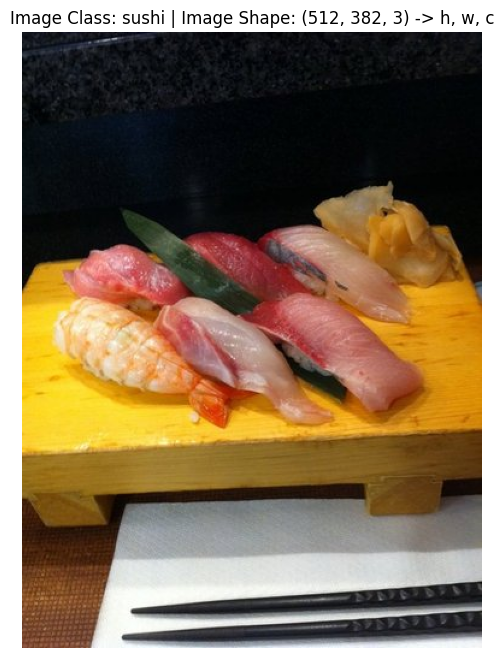

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Image to array
img_to_array = np.asarray(img)

# Plotting the image
plt.figure(figsize=(10, 8))
plt.imshow(img_to_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_to_array.shape} -> h, w, c")
plt.axis(False)
plt.show()

array([[[ 22,  25,  32],
        [ 20,  23,  30],
        [ 17,  20,  27],
        ...,
        [ 12,  15,  20],
        [  9,  12,  17],
        [  5,   8,  13]],

       [[ 20,  23,  30],
        [ 21,  24,  31],
        [ 21,  24,  31],
        ...,
        [ 13,  16,  21],
        [ 10,  13,  18],
        [  6,   9,  14]],

       [[ 14,  17,  24],
        [ 16,  19,  26],
        [ 18,  21,  28],
        ...,
        [ 14,  17,  22],
        [ 12,  15,  20],
        [  9,  12,  17]],

       ...,

       [[133,  78,  57],
        [139,  84,  63],
        [143,  88,  67],
        ...,
        [245, 246, 248],
        [244, 245, 247],
        [244, 245, 247]],

       [[131,  76,  55],
        [144,  89,  68],
        [143,  88,  67],
        ...,
        [245, 245, 245],
        [243, 243, 243],
        [242, 242, 242]],

       [[119,  64,  43],
        [142,  87,  66],
        [134,  79,  58],
        ...,
        [248, 248, 248],
        [245, 245, 245],
        [243, 243, 243]]], dtype=uint8)
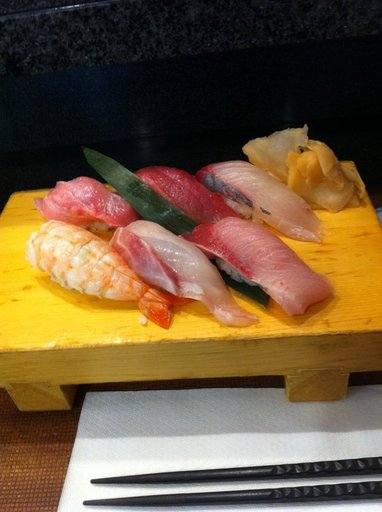

In [9]:
img_to_array

## 4. Turning images to PyTorch tensors and transforming
* Numerical representation of images
* Turning to *torch.utils.data.DataSet* and simultaneously turning dataset into *torch.utils.data.DataLoader*
* torch.utils.data.DataSet to house all the data to tensor format
* torch.utils.data.DataLoader creates an iterable or a batched version of dataset

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Transforming data with torchvision.transforms
* Helps to get the inages ready to be used with a model augmentation

In [11]:
### Transforming data with torchvision.transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.0667, 0.0745, 0.0627,  ..., 0.0863, 0.0824, 0.0706],
         [0.0510, 0.0745, 0.0627,  ..., 0.0941, 0.0941, 0.0902],
         [0.0510, 0.0549, 0.0667,  ..., 0.0980, 0.0824, 0.1098],
         ...,
         [0.1294, 0.1490, 0.1412,  ..., 0.4863, 0.4863, 0.4863],
         [0.4118, 0.3961, 0.3804,  ..., 0.4784, 0.4745, 0.4784],
         [0.8824, 0.8745, 0.8667,  ..., 0.4941, 0.4941, 0.4980]],

        [[0.0745, 0.0784, 0.0627,  ..., 0.0980, 0.0941, 0.0824],
         [0.0588, 0.0784, 0.0667,  ..., 0.1098, 0.1098, 0.1098],
         [0.0549, 0.0588, 0.0706,  ..., 0.1176, 0.1059, 0.1333],
         ...,
         [0.1294, 0.1451, 0.1451,  ..., 0.2941, 0.2902, 0.2941],
         [0.4118, 0.4000, 0.3882,  ..., 0.2863, 0.2784, 0.2824],
         [0.8902, 0.8902, 0.8784,  ..., 0.2941, 0.2941, 0.2902]],

        [[0.0941, 0.0941, 0.0863,  ..., 0.1333, 0.1255, 0.1098],
         [0.0745, 0.0863, 0.0824,  ..., 0.1490, 0.1451, 0.1373],
         [0.0706, 0.0667, 0.0784,  ..., 0.1529, 0.1373, 0.

## 5. Loading Image data using ImageFolder
* ImageFolder is an pre-built datasets function
* Load / Transform image classification data using *torchvision.datasets.ImageFolder*

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, ## Transforming the ip data
                                  target_transform=None) ## Tranforming the label data

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
len(train_data)

225

In [17]:
## Getting a single image and label using index on train_data
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(class_names[label])
print(f"Label Datatype: {type(label)}")

Image Tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original Shape is: torch.Size([3, 64, 64]) -> [c, h, w]
Permuted Image: torch.Size([64, 64, 3]) -> [h, w, c]


Text(0.5, 1.0, 'pizza')

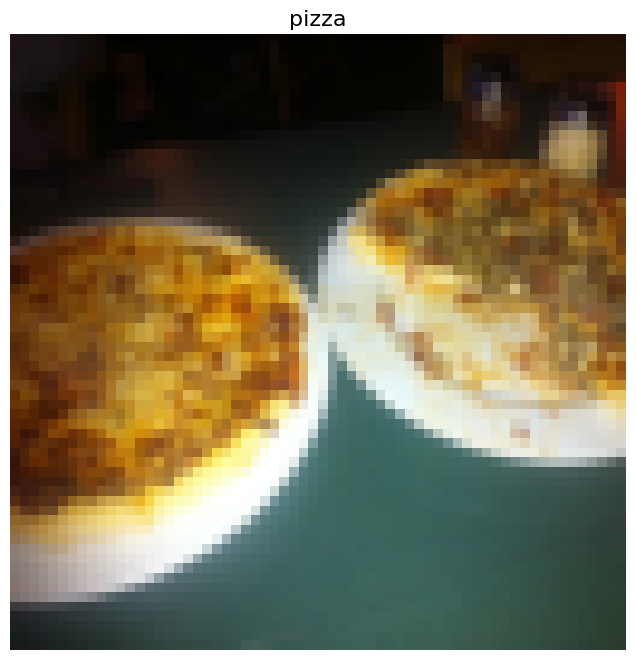

In [18]:
img_permute = img.permute(1,2,0)

print(f"Original Shape is: {img.shape} -> [c, h, w]")
print(f"Permuted Image: {img_permute.shape} -> [h, w, c]")

#Plotting
plt.figure(figsize=(10, 8))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=16)

## Turning loaded images into DataLoaders for batching
* Datsets can be turned into iterable_to_str*
* A batch_size can be ustomized, so that the model can see batch_size images at once (cause without batch size, loading all the images will lead to the hardware running out of memory)

In [19]:
## Turning train and test datasets to dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 5
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e1efcb1e2a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e1efcab8080>)

In [20]:
len(train_dataloader), len(test_dataloader)

(45, 15)

In [21]:
img, label = next(iter(train_dataloader))

# Batch size is 5
print(f"Image Shape: {img.shape}")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([5, 3, 64, 64])
Label Shape: torch.Size([5])


<!-- ## 5.1 Loading Image data with a custom dataset
* Load images and get class names from dataset
* Able to get classes as dictionary from the dataset
* Using a custom dataset often results in writing more code
  -->

## 6. Data Augmentation
* A process of adding the modified copies of already existing data to training data
* Applying various image tarnsformations to train data, incase of image data
* Looking at the same image in a different persepective to increase the diversity of a dataset or image, which results the model to see the unseen image in different angles
* Types like rotate, shift, cropping, replacing, zooming etc
* Used Trivial augmentation ie applying very simple, low-risk data augmentations

In [34]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 31 is max number on a scale of 0-31 ie how intense the augment should happen
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [29]:
image_path

PosixPath('data/pizza_steak_sushi')

In [31]:
data_path

PosixPath('data')

In [33]:
## Getting all of the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/sushi/748830.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1232045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2574453.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3737197.jpg')]

# Model Buidling (without data augmentation)
* Using the CNN TinyVGG architecture

## 1. Loading Data

In [36]:
## Creating a transform to load the data, images and turning to tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [37]:
## Using ImageFolder
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform = data_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=data_transform)

## Datasets to dataloaders
import os
from torch.utils.data import DataLoader

## Batzh size
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

## Creating data laoder
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [38]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    # Convolution block 1
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    # Convolution block 2
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return x

In [39]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # Color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=3, bias=True)
  )
)